In [28]:
import pywt
import numpy as np
import scipy.ndimage as scimg
from scipy.misc import imresize
from skimage.measure import compare_psnr

import matplotlib.pyplot as plt

%matplotlib inline

In [64]:
def get_data(nx = 128, ny = 127):
    url_img = '../noniterative/data/original/SRCNN/Test/Set14/baboon.bmp'
    img = scimg.imread(url_img, flatten=True, mode='L')
    img_resize = imresize(img, (nx,ny)) #/255.0
    print ('Image Size:', img_resize.shape)

# METHOD 1 (using PyWavelets library)

Image Size: (128, 128)
cA: (65, 65)
cH: (65, 65)
cV: (65, 65)
cD: (65, 65)


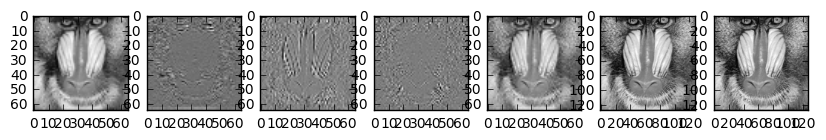

In [46]:
def pywavelets_trial():
    wavelet = 'haar'
    wavelet = 'db2'
    modes = ['zero', 'constant', 'symmetric', 'reflect', 'periodic', 'smooth', 'periodization']
    mode = modes[3]

    coeffs = pywt.dwt2(img_resize, wavelet, mode=mode)
    cA, (cH, cV, cD) = coeffs
    cAll = cA + cH + cV + cD
    img_resize_recon = pywt.idwt2(coeffs, wavelet, mode=mode)


    f, axarr = plt.subplots(1,7, figsize=(10,10))
    axarr[0].imshow(cA, cmap='gray')
    axarr[1].imshow(cH, cmap='gray')
    axarr[2].imshow(cV, cmap='gray')
    axarr[3].imshow(cD, cmap='gray')
    axarr[4].imshow(cA + cH + cV + cD, cmap='gray')
    axarr[5].imshow(img_resize, cmap='gray')
    axarr[6].imshow(img_resize_recon, cmap='gray')
    """
    a - LL, low-low coefficients (approximate)
    h - LH, low-high coefficients (horizontal) 
    v - HL, high-low coefficients (vertical)
    d - HH, high-high coefficients (diagonal)
    """

    print ('cA:', cA.shape)
    print ('cH:', cH.shape)
    print ('cV:', cV.shape)
    print ('cD:', cD.shape)

# METHOD 2 (using self defined functions)
[Blog Post](https://kastnerkyle.github.io/posts/wavelets/)

In [62]:
class Haar():
    
    def haar_matrix(self, size):
        level = int(np.ceil(np.log2(size)))
        H = np.array([1.])[:, None]
        NC = 1. / np.sqrt(2.)
        LP = np.array([1., 1.])[:, None] 
        HP = np.array([1., -1.])[:, None]
        for i in range(level):
            H = NC * np.hstack((np.kron(H, LP), np.kron(np.eye(len(H)),HP)))
        H = H.T
        return H

    def dwt(self, x):
        H = haar_matrix(x.shape[0])
        x = x.ravel()
        #Zero pad to next power of 2
        x = np.hstack((x, np.zeros(H.shape[1] - x.shape[0])))
        return np.dot(H, x)

    def idwt(self, x):
        H = haar_matrix(x.shape[0])
        x = x.ravel()
        #Zero pad to next power of 2
        x = np.hstack((x, np.zeros(H.shape[0] - x.shape[0])))
        return np.dot(H.T, x)

    def wthresh(self, a, thresh):
        #Soft threshold
        res = np.abs(a) - thresh
        return np.sign(a) * ((res > 0) * res)

    def dwt2d(self, x):
        H = self.haar_matrix(x.shape[0])
        # print ('Haar Matrix:', H)
        return np.dot(np.dot(H, x), H.T)       

    def idwt2d(self, x):
        H = self.haar_matrix(x.shape[0])
        return np.dot(np.dot(H.T, x), H)  

Image Size: (128, 128)
238 4
Haar Matrix: [[ 0.08838835  0.08838835  0.08838835 ...,  0.08838835  0.08838835
   0.08838835]
 [ 0.08838835  0.08838835  0.08838835 ..., -0.08838835 -0.08838835
  -0.08838835]
 [ 0.125       0.125       0.125      ..., -0.         -0.         -0.        ]
 ..., 
 [ 0.         -0.          0.         ..., -0.          0.         -0.        ]
 [ 0.         -0.          0.         ..., -0.70710678  0.         -0.        ]
 [ 0.         -0.          0.         ..., -0.          0.70710678
  -0.70710678]]
Reduction: using 43.68 percent the coefficients of the original


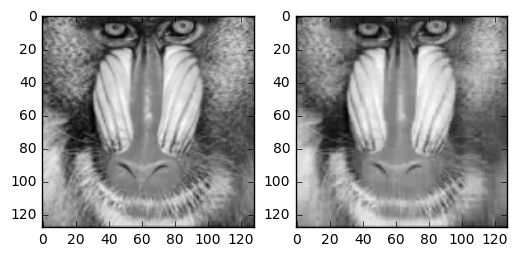

In [63]:
if __name__ == "__main__":
    pass
#     print ('Image Size:', img_resize.shape)
#     print (np.amax(img_resize), np.amin(img_resize))

#     haar = Haar()
#     alpha_wave = haar.dwt2d(img_resize)
#     alpha_wave_sampled = haar.wthresh(alpha_wave, 10)
#     alpha_wave_recon = haar.idwt2d(alpha_wave_sampled)

#     alpha_wave_nz = len(alpha_wave.nonzero()[0]) + len(alpha_wave.nonzero()[1])
#     alpha_wave_sampled_nz = len(alpha_wave_sampled.nonzero()[0]) + len(alpha_wave_sampled.nonzero()[1])

#     reduction = 'using %.2f percent the coefficients of the original' % (100 * float(alpha_wave_sampled_nz) / alpha_wave_nz)

#     f, axarr = plt.subplots(1,2)
#     axarr[0].imshow(img_resize, cmap='gray')
#     axarr[1].imshow(alpha_wave_recon, cmap='gray')

#     print ('Reduction:', reduction)
#     # print ('pSNR:', compare_psnr(img_resize.astype(np.float16), alpha_wave_recon.astype(np.float16)), dynamic_range = 234)